<a href="https://colab.research.google.com/github/lkforward/flower/blob/master/run_cloud_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install catalyst
!pip install pretrainedmodels
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install pytorch_toolbelt
!pip install torchvision==0.4
!pip install albumentations==0.3.2

In [0]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import torch as AT

import gc

In [0]:
from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp

In [0]:
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" /content/gdrive/My\ Drive/kaggle_cloud/apex
from apex import amp

# Helper Functions



In [0]:
def get_img(x, folder: str='train_images'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{path}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.

    [OUTPUTS]:
    masks: an array with shape (shape[0], shape[1], 4).
      Mask for each class labels.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)


    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)


    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)

  
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_training_augmentation():
    """
    Define the preprocessing for the training data. 
    """
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        # albu.Resize(320, 640)
        albu.Resize(160, 320)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        # albu.Resize(320, 640)
        albu.Resize(160, 320)
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.augmentations.transforms.Lambda(image=preprocessing_fn),
        albu.augmentations.transforms.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

In [0]:
path = '/content/gdrive/My Drive/kaggle_cloud/data'


def get_data(path, n_samples=None):
  """
  Read the taining data information, including image id and labels. 
  """
  train = pd.read_csv(f'{path}/train.csv')
  sub = pd.read_csv(f'{path}/sample_submission.csv')
  print("Reading the training csv...")
  print(train.columns)
  print(train.shape)

  n_train = len(os.listdir(f'{path}/train_images'))
  print("Reading the training images...")
  print(f'There are {n_train} images in the original train dataset')

  if n_samples: 
    train = train.iloc[:n_samples, :]
    print(f'Use {n_samples} images within the training dataset.')


  train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
  train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

  sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
  sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

  return train, sub


def display_images_with_masks(path, train):
  """
  Randomly choose 4 images from the training dataset, and plot them with the masks.
  """

  fig = plt.figure(figsize=(25, 16))
  for j, im_id in enumerate(np.random.choice(train['im_id'].unique(), 4)):
      for i, (idx, row) in enumerate(train.loc[train['im_id'] == im_id].iterrows()):
          ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
          im = Image.open(f"{path}/train_images/{row['Image_Label'].split('_')[0]}")
          plt.imshow(im)
          mask_rle = row['EncodedPixels']
          try: # label might not be there!
              mask = rle_decode(mask_rle)
          except:
              mask = np.zeros((1400, 2100))
          plt.imshow(mask, alpha=0.5, cmap='gray')
          ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")


def split_data(train, sub):
  """
  Split the training dataset into train/valid datasets, and use all the data in 
  the submission dataset as test data. 

  [OUTPUTS]:
  train_ids/valid_ids/test_ids: array of image ids(str). 
  """
  train_labels = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label']
  id_mask_count = train_labels.apply(lambda x: x.split('_')[0]).value_counts()
  id_mask_count = id_mask_count.reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
  train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values,
                                          random_state=42,
                                          stratify=id_mask_count['count'],
                                          test_size=0.1)
 
  # Alternatively, we can use sub['im_id'] directly. 
  test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values
  
  return train_ids, valid_ids, test_ids


class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),AT.ToTensor()]),
                 preprocessing=None):
        """
        [INPUTS]:
        df: a pandas dataframe. 
          The image information dataframe, obtained from function "get_data()".
        datatype: string. 
          Whether it is 'train' or 'test'. 
        
        """
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{path}/train_images"
        else:
            self.data_folder = f"{path}/test_images"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

From the \_\_getitem\_\_() method we can tell that the 'y' in the training data actually is the mask, which has a shape of (W, L, 4). The value of the mask is binary. 

# Load Dataset

In [10]:
train, sub = get_data(path)

Reading the training csv...
Index(['Image_Label', 'EncodedPixels'], dtype='object')
(22184, 2)
Reading the training images...
There are 5546 images in the original train dataset


In [11]:
print(train.shape)
train.head()

(22184, 4)


,Image_Label,EncodedPixels,label,im_id
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,Fish,0011165.jpg
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,Flower,0011165.jpg
2,0011165.jpg_Gravel,NaN,Gravel,0011165.jpg
3,0011165.jpg_Sugar,NaN,Sugar,0011165.jpg
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,Fish,002be4f.jpg


In [0]:
df = train
encoded_masks = df.loc[df['im_id'] == '550fbec.jpg', 'EncodedPixels']

In [28]:
print(encoded_masks)
mask_cls1 = rle_decode(encoded_masks.values[0])
print()
print("The shape of the mask:", mask_cls1.shape)
print(mask_cls1)
# x = rle_decode(encoded_masks[0])
# type(x)

7424    820 580 2220 580 3620 580 5020 580 6420 580 78...
7425    28259 656 29659 656 31059 656 32459 656 33859 ...
7426                                                  NaN
7427                                                  NaN
Name: EncodedPixels, dtype: object

The shape of the mask: (1400, 2100)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


**NOTE**: So from the above, the "encodedPixels" represents a binary mask whose shape can be anything (not just a rectangle, as seen from the plots below), no matter how long the length of the "encodedPixels" is.

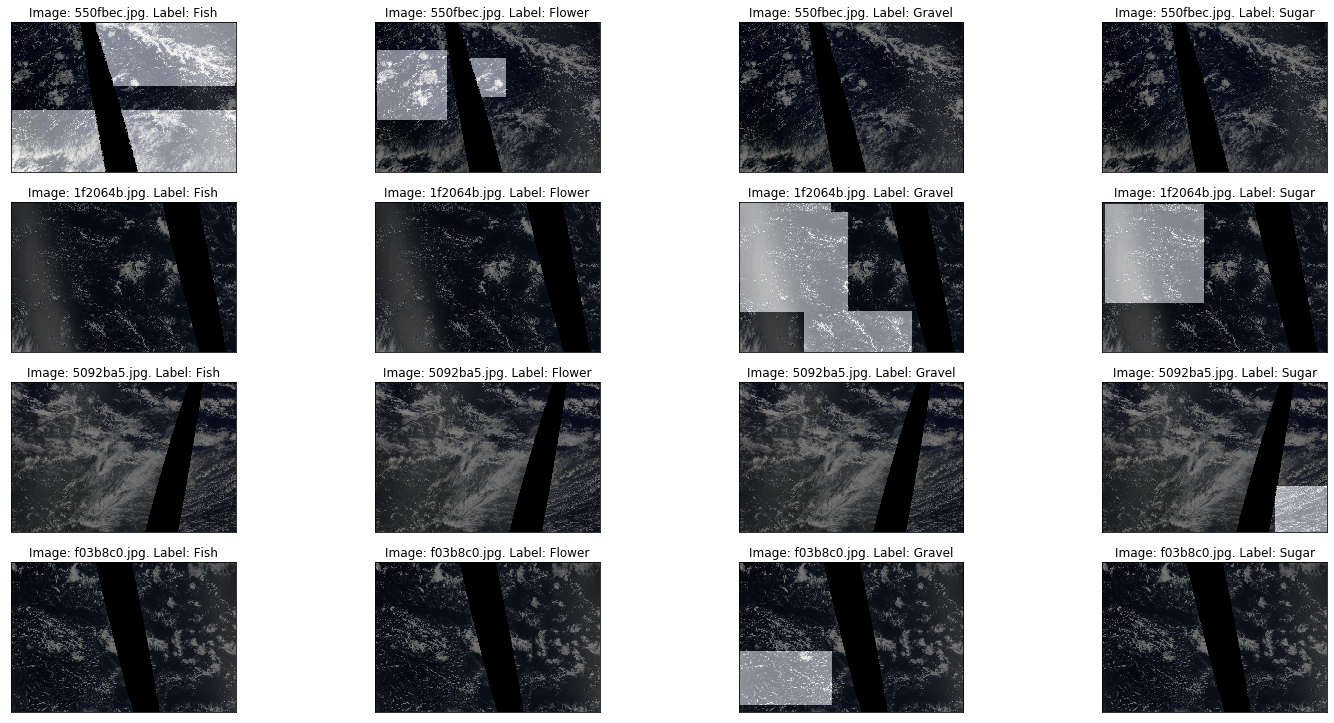

In [12]:
display_images_with_masks(path, train)

In [0]:
train_ids, valid_ids, test_ids = split_data(train, sub)

print('The size of training sample:', train_ids.shape)
print('The size of validation sample:', valid_ids.shape)
print('The size of testing sample:', test_ids.shape)

The size of training sample: (4991,)
The size of validation sample: (555,)
The size of testing sample: (3698,)


# Build the Model

In [0]:
DEVICE = 'cuda'

# ENCODER = 'resnet50'
ENCODER = 'inceptionresnetv2'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

num_workers = 0
bs = 16
train_dataset = CloudDataset(df=train, datatype='train', img_ids=train_ids, 
                             transforms = get_training_augmentation(), 
                             preprocessing=get_preprocessing(preprocessing_fn))

valid_dataset = CloudDataset(df=train, datatype='valid', img_ids=valid_ids, 
                             transforms = get_validation_augmentation(), 
                             preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, 
                          num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, 
                          num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/checkpoints/inceptionresnetv2-520b38e4.pth
100%|██████████| 213M/213M [10:39<00:00, 350kB/s]
/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2247: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [0]:
num_epochs = 19
logdir = '/content/gdrive/My Drive/kaggle_cloud/log_resize_input_160by320'

# model, criterion, optimizer
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])

opt_level = 'O1'
model.cuda()
model, optimizer = amp.initialize(model, optimizer, opt_level=opt_level)

scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)
runner = SupervisedRunner()

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [0]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(), EarlyStoppingCallback(patience=5, min_delta=0.001)],
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

# Visualize the Model Accuracy

In [0]:
import json
metric_file = os.path.join(logdir, 'checkpoints/_metrics.json')

with open(metric_file, 'r') as f:
  metrics = json.load(f)

In [0]:
print(metrics.keys())
metrics['epoch_6']

dict_keys(['best', 'last', 'train.19', 'epoch_0', 'epoch_1', 'epoch_2', 'epoch_3', 'epoch_4', 'epoch_5', 'epoch_6', 'epoch_7', 'epoch_8', 'epoch_9', 'epoch_10', 'epoch_11', 'epoch_12', 'epoch_13', 'epoch_14', 'epoch_15', 'epoch_16', 'epoch_17', 'epoch_18'])


['/content/gdrive/My Drive/kaggle_cloud/run_log1109/checkpoints/train.7.pth',
 0.8074309161731174,
 {'_base/lr': 0.01,
  '_base/momentum': 0.9,
  '_timers/_fps': 9.615288928372232,
  '_timers/batch_time': 1.6704837254115512,
  '_timers/data_time': 1.6501800673348563,
  '_timers/model_time': 0.020228951317923415,
  'dice': 0.5196731337479185,
  'loss': 0.8074309161731174}]

In [0]:
def plot_metrics_json(metric_file, metric_name, n_epochs, do_save_fig=False, figname=None):
  """
  Plot the change of a metric in the training process saved in a *.json file.

  metric_name: str. 
    The name of the metric variable. Choose from: '_base/lr', 'dice', 'loss'. 
  """

  with open(metric_file, 'r') as fm: 
    metrics = json.load(fm)

    metric_hist = []
    for i in range(n_epochs):
      metric_i = metrics['epoch_{}'.format(i)][2][metric_name]
      metric_hist.append(metric_i)

  plt.plot(range(n_epochs), metric_hist)
  plt.xlabel('Epochs')
  plt.ylabel(metric_name)

  if do_save_fig:
    if not figname:
      figname = metric_file.replace('_metrics.json', metric_name + '.png')
      print(figname)
    plt.savefig(figname)

/content/gdrive/My Drive/kaggle_cloud/run_log1109/checkpoints/loss.png


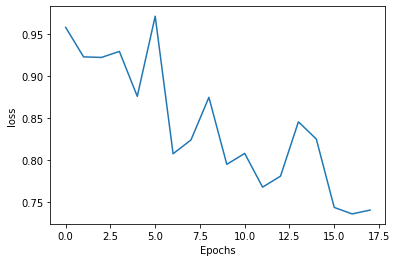

In [0]:
plot_metrics_json(metric_file, metric_name='loss', n_epochs=18, do_save_fig=True)

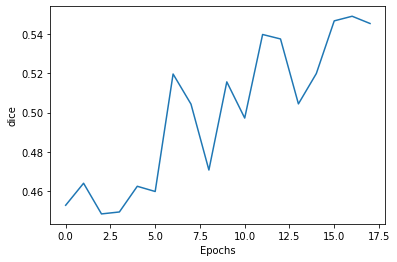

In [0]:
plot_metrics_json(metric_file, metric_name='dice', n_epochs=18)

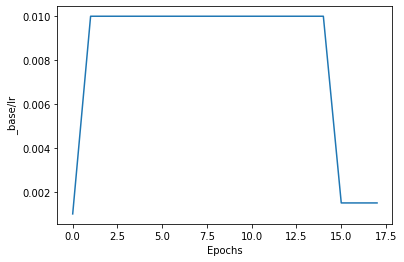

In [0]:
plot_metrics_json(metric_file, metric_name='_base/lr', n_epochs=18)

# Load the Model and Make Inference

In [0]:
# Step 1. Load the trained model
# logdir = '/content/gdrive/My Drive/kaggle_cloud/log_inceptionresnetv2/'
path_to_checkpoint = os.path.join(logdir, 'checkpoints/best_full.pth')
checkpoint = torch.load(path_to_checkpoint)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
runner = SupervisedRunner(model=model)

In [0]:
checkpoint.keys()

dict_keys(['epoch_metrics', 'valid_metrics', 'stage', 'epoch', 'checkpoint_data', 'model_state_dict', 'criterion_state_dict', 'optimizer_state_dict', 'scheduler_state_dict'])

In [0]:
# Step 3. Make predictions
import gc
torch.cuda.empty_cache()
gc.collect()

25122

In [0]:
# Step 2. Select the "best parameters"
encoded_pixels = []
loaders = {"infer": valid_loader}
runner.infer(
    model=model,
    loaders=loaders,
    callbacks=[
        CheckpointCallback(
            resume=f"{logdir}/checkpoints/best.pth"),
        InferCallback()
    ],
)
valid_masks = []
probabilities = np.zeros((2220, 350, 525))
for i, (batch, output) in enumerate(tqdm.tqdm(zip(
        valid_dataset, runner.callbacks[0].predictions["logits"]))):
    image, mask = batch
    for m in mask:
        if m.shape != (350, 525):
            m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        valid_masks.append(m)

    for j, probability in enumerate(output):
        if probability.shape != (350, 525):
            probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        probabilities[i * 4 + j, :, :] = probability

=> loading checkpoint /content/gdrive/My Drive/kaggle_cloud/run_log1109/checkpoints/best.pth
loaded checkpoint /content/gdrive/My Drive/kaggle_cloud/run_log1109/checkpoints/best.pth (epoch 19)
Top best models:



555it [01:09,  7.94it/s]


In [0]:
# For each class, find a best parameter ('threshold' and 'size')
class_params = {}
for class_id in range(4):
    print(class_id)
    attempts = []
    for t in range(0, 100, 5):
        t /= 100
        for ms in [0, 100, 1200, 5000, 10000]:
            masks = []
            for i in range(class_id, len(probabilities), 4):
                probability = probabilities[i]
                predict, num_predict = post_process(sigmoid(probability), t, ms)
                masks.append(predict)

            d = []
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))

            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])


    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    
    class_params[class_id] = (best_threshold, best_size)

print(class_params)

0
    threshold   size      dice
64       0.60  10000  0.617677
59       0.55  10000  0.614424
44       0.40  10000  0.611265
69       0.65  10000  0.609774
54       0.50  10000  0.609170
1
    threshold   size      dice
39       0.35  10000  0.760165
53       0.50   5000  0.760070
44       0.40  10000  0.759396
59       0.55  10000  0.759296
48       0.45   5000  0.758921
2
    threshold   size      dice
74       0.70  10000  0.601254
59       0.55  10000  0.600889
69       0.65  10000  0.599362
64       0.60  10000  0.598662
79       0.75  10000  0.597799
3
    threshold   size      dice
54       0.50  10000  0.621536
59       0.55  10000  0.618383
49       0.45  10000  0.615997
64       0.60  10000  0.614372
63       0.60   5000  0.614245
{0: (0.6, 10000), 1: (0.35, 10000), 2: (0.7, 10000), 3: (0.5, 10000)}


In [0]:
test_dataset = CloudDataset(df=sub, datatype='test', img_ids=test_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

loaders = {"test": test_loader}

encoded_pixels = []
image_id = 0
for i, test_batch in enumerate(tqdm.tqdm(loaders['test'])):
    runner_out = runner.predict_batch({"features": test_batch[0].cuda()})['logits']
    for i, batch in enumerate(runner_out):
        for probability in batch:
            
            probability = probability.cpu().detach().numpy()
            if probability.shape != (350, 525):
                probability = cv2.resize(probability, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
            predict, num_predict = post_process(sigmoid(probability), class_params[image_id % 4][0], class_params[image_id % 4][1])
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(predict)
                encoded_pixels.append(r)
            image_id += 1

sub['EncodedPixels'] = encoded_pixels
sub.to_csv(os.path.join(logdir, 'submission.csv'), columns=['Image_Label', 'EncodedPixels'], index=False)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2247: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

 24%|██▍       | 113/463 [10:00<26:13,  4.50s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: RuntimeWarning:

overflow encountered in exp

100%|██████████| 463/463 [36:33<00:00,  4.74s/it]
